# **EXPERIMENT 4:** Prototype `Research Agent` with Agent Component

# 1. Introduction


*   This experiment prototypes the existing Research Agent using the new Agent and utilizes experimental MultiFileConverter SuperComponent for our use-case.

# 2. Setup Phase

In [1]:
! uv pip install haystack-ai haystack-experimental google-ai-haystack duckduckgo-api-haystack python-dotenv jsonschema trafilatura pypdf markdown-it-py mdit_plain docstring-parser python-pptx python-docx jq pandas openpyxl tabulate

Using Python 3.13.2 environment at: C:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv
Audited 17 packages in 14ms


### Load `.env` file

In [2]:
from dotenv import load_dotenv

load_dotenv() # Load environment variable

True

### Import Packages

In [3]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.agents import Agent 
from haystack.components.fetchers import LinkContentFetcher
from haystack_experimental.super_components.converters import MultiFileConverter
from haystack.components.builders.chat_prompt_builder import ChatPromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator
from duckduckgo_api_haystack import DuckduckgoApiWebSearch
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.dataclasses import ChatMessage
from haystack.tools.tool import Tool
from haystack.core.super_component import SuperComponent
from haystack.tools import ComponentTool

c:\Users\angel\Documents\GitHub\ambitus-ai-models\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Search Tool Setup

### Initializing Tool Pipeline

In [4]:
search_pipe = Pipeline()
""" 
prompt_template = [
    ChatMessage.from_user(
    '''
    According to the following documents:
    {% for document in documents %}
    {{document.content}}
    {% endfor %}
    '''
    )
]

prompt_template2 = [
    ChatMessage.from_user(
    '''
    {% for doc in docs %}
    <search-result url="{{ doc.meta.url }}">
    {{ doc.content|default|truncate(25000) }}
    </search-result>
    {% endfor %}
    '''
    )
]
 """
search_pipe.add_component("search", DuckduckgoApiWebSearch(top_k=10, backend="html"))
search_pipe.add_component("fetcher", LinkContentFetcher(timeout=3, raise_on_failure=False, retry_attempts=2))
search_pipe.add_component("converter", MultiFileConverter())
search_pipe.add_component(
    "prompt_builder", 
    ChatPromptBuilder(
        template=[
            ChatMessage.from_user(
                """
                {% for doc in docs %}
                <search-result url="{{ doc.meta.link }}">
                {{ doc.content|default|truncate(25000) }}
                </search-result>
                {% endfor %}
                {% for document in documents %}
                {{document.content}}
                {% endfor %}
                """
            )
        ],
        variables=["docs", "documents"],
        required_variables=["docs", "documents"]
    )
)

### Connections

In [5]:
search_pipe.connect("search.links", "fetcher.urls")
search_pipe.connect("fetcher.streams", "converter.sources")
search_pipe.connect("converter.documents", "prompt_builder.documents")
search_pipe.connect("search.documents", "prompt_builder.docs")

🚅 Components
  - search: DuckduckgoApiWebSearch
  - fetcher: LinkContentFetcher
  - converter: MultiFileConverter
  - prompt_builder: ChatPromptBuilder
🛤️ Connections
  - search.links -> fetcher.urls (List[str])
  - search.documents -> prompt_builder.docs (List[Document])
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> prompt_builder.documents (List[Document])

### Visualization

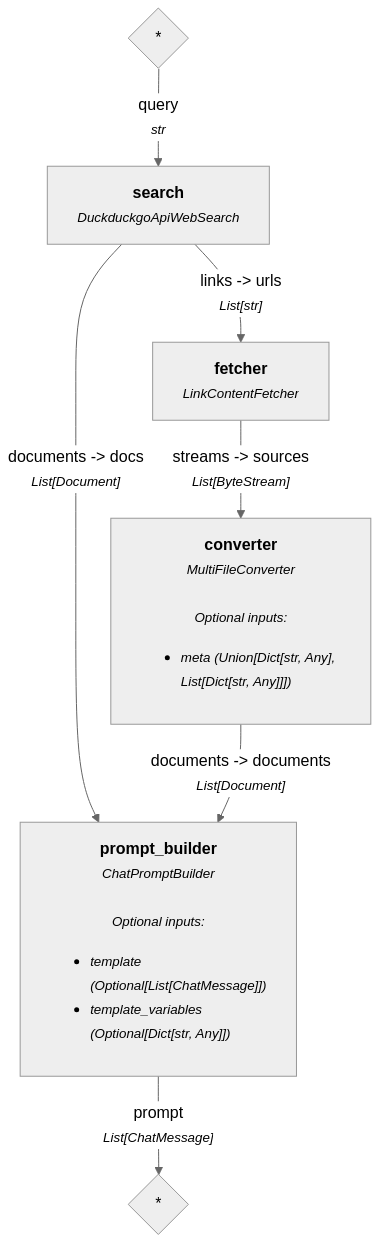

In [6]:
search_pipe.show()

### Testing Pipeline

In [7]:
search_query = "Zepto business model and strategy analysis"

test_response = search_pipe.run(
    {"query": search_query},
)

In [8]:
test_response

{'prompt_builder': {'prompt': [ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text='\n                \n                <search-result url="https://startuptalky.com/zepto-business-model/">\n                The "dark store model" serves as the foundation for Zepto\'s business model. This involves setting up delivery-only warehouse-style stores in residential regions. The shops sell a variety of products, and the sole way for buyers to place orders is through the Zepto India website or app. Across multiple regions, Zepto now has more than eighty-six ...\n                </search-result>\n                \n                <search-result url="https://www.inspirajournals.com/uploads/Issues/1841235791.pdf">\n                business model as they have still not made the business profitable. Zepto is also facing tough competition from its rival Blinkit (formerly known as Grofers) who was founded in December 2013. _____ Keywords: Zepto, Start-up, E-commerce, Business Model, P

### Tooling

In [9]:
# Wrap in SuperComponent + ComponentTool
search_tool_component = SuperComponent(
    pipeline=search_pipe,
    input_mapping={
        "query": ["search.query"],
    },
    output_mapping={"prompt_builder.prompt": "replies"}
    )
search_tool = ComponentTool(
    name="webSearch",
    description="Use this tool to search for information on the internet to be added in the research work. Input format: {query: <search query>}",
    component=search_tool_component
)

# 4. Agent Setup

## Utilising LLM: `gemini-2.5-pro-exp-03-25`

### Initialisation

In [44]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.5-pro-exp-03-25")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
Break the user question into smaller parts and answer each part separately using tools.
You MUST use the 'search_tool'-tool to answer any questions.
You MUST utilize the 'search_tool'-tool to search for information on the internet.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately, use links from 'search_tool' tool ONLY.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [45]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."

if messages:
    messages.clear() # Clear previous messages

messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nBreak the user question into smaller parts and answer each part separately using tools.\nYou MUST use the 'search_tool'-tool to answer any questions.\nYou MUST utilize the 'search_tool'-tool to search for information on the internet.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately, use links from 'search_tool' tool ONLY.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently 

## Understanding Response

### Raw Response

In [46]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nBreak the user question into smaller parts and answer each part separately using tools.\nYou MUST use the 'search_tool'-tool to answer any questions.\nYou MUST utilize the 'search_tool'-tool to search for information on the internet.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately, use links from 'search_tool' tool ONLY.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's cu

In [47]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Okay, here is an analysis of Zepto's current business, technical, and marketing strategies, drawing upon available information.

***

## Zepto: Analysis of Business, Technical, and Marketing Strategies

Zepto, an Indian quick commerce company founded in 2021, has rapidly gained prominence by promising grocery and essential item delivery within 10 minutes. This analysis explores its core strategies across business, technology, and marketing, and how they contribute to its growth.

### 1. Business Strategy

Zepto's business strategy revolves around speed, density, and operational efficiency within the quick commerce (q-commerce) model.

*   **Core Model: Quick Commerce & Dark Stores:** Zepto operates on a hyperlocal delivery model using a network of "dark stores" or micro-fulfillment centers. These are strategically located in high-demand neighborhoods, enabling riders to pick up orders and deliver them within the promised 10-minute timeframe [Source: Zepto](https://www.zeptonow.com/). This differs significantly from traditional e-commerce which relies on larger, more distant warehouses.
*   **Focus on Density and Efficiency:** The model's success hinges on high population density and optimizing every step of the process – from inventory management in the dark store to last-mile delivery route planning. Zepto aims for operational efficiency to manage the costs associated with rapid delivery [Source: Business Standard](https://www.business-standard.com/companies/start-ups/how-zepto-is-optimising-delivery-operational-efficiency-in-quick-commerce-124022700707_1.html).
*   **Expansion and Market Position:** Zepto expanded rapidly across major Indian cities after its launch. While initially focused purely on speed, there's evidence suggesting a maturing strategy focusing on sustainable growth and improving unit economics [Source: Business Standard](https://www.business-standard.com/companies/start-ups/how-zepto-is-optimising-delivery-operational-efficiency-in-quick-commerce-124022700707_1.html). They achieved Unicorn status (valuation over $1 billion) remarkably quickly, indicating strong investor confidence in their model and execution [Source: Forbes India](https://www.forbesindia.com/article/startups/zepto-founders-aadit-palicha-and-kaivalya-vohra-the-fast-and-the-furious/80269/1).
*   **Path to Profitability:** Like many players in the q-commerce space, achieving profitability is a key challenge. Zepto has indicated a focus on improving its Average Order Value (AOV) and optimizing its dark store network and supply chain to move towards profitability, potentially ahead of an Initial Public Offering (IPO) in the future [Source: Inc42 Media](https://inc42.com/buzz/ahead-of-ipo-zepto-looks-to-achieve-profitability-eyes-positive-cash-flow-in-fy25/).

**Contribution to Growth:** The core 10-minute delivery promise, enabled by the dark store network, was a major differentiator that fueled initial rapid customer acquisition and market share gains in a competitive landscape. Raising significant funding allowed for aggressive expansion and scaling of this model [Source: Forbes India](https://www.forbesindia.com/article/startups/zepto-founders-aadit-palicha-and-kaivalya-vohra-the-fast-and-the-furious/80269/1).

### 2. Technical Strategy

Technology is fundamental to Zepto's operations, enabling the speed and efficiency required for quick commerce.

*   **Key Technical Domains:**
    *   **Logistics & Supply Chain Management:** This is paramount. Technology optimizes inventory placement within dark stores, predicts demand, manages stock levels in real-time, and plans the most efficient delivery routes.
    *   **Location Intelligence:** Precisely mapping dark store locations, understanding delivery zones, and real-time tracking of riders are crucial.
    *   **Data Analytics & AI/ML:** Zepto heavily utilizes data to forecast demand patterns, optimize store layouts for faster picking, personalize customer experiences, and improve overall operational decision-making [Source: Analytics India Magazine](https://analyticsindiamag.com/zepto-data-science-team-ai-ml-models/).
    *   **Mobile Application:** The customer-facing app needs to be seamless, fast, and reliable, providing accurate order tracking and a smooth user experience. Backend systems must handle high transaction volumes efficiently.
*   **Ongoing/Upcoming Projects (Inferred):** While specific internal project names aren't public, ongoing efforts likely focus on:
    *   Improving prediction accuracy for demand forecasting.
    *   Enhancing route optimization algorithms to reduce delivery times further and minimize costs.
    *   Developing more sophisticated inventory management systems to reduce waste and ensure availability.
    *   Experimenting with AI for personalized recommendations and promotions within the app.
    *   Potentially exploring automation within dark stores where feasible.
*   **Recently Released Products/Features:** Rather than physical products, Zepto's "releases" often involve service expansions or app features. Examples could include:
    *   **Category Expansions:** Adding new product categories beyond basic groceries (e.g., snacks, beverages, personal care, potentially basic pharmacy items where regulations allow).
    *   **Zepto Café:** Launching services like Zepto Café, offering quick snacks and beverages, leverages the existing delivery infrastructure for a new use case [Source: Inc42 Media](https://inc42.com/buzz/zepto-turns-profitable-at-ebitda-level-launches-zepto-cafe/).
    *   **Private Labels:** Introducing own-brand products ('Zepto Bloom Farm', 'Zepto Essentials') to improve margins [Source: Entrackr](https://entrackr.com/2024/06/zepto-launches-private-labels-in-multiple-categories/).

**Contribution to Growth:** Zepto's sophisticated tech stack is the engine behind its value proposition. It allows them to execute the complex logistics of 10-minute delivery consistently, which builds customer trust and loyalty. Data analytics helps optimize operations, control costs, and improve unit economics, contributing to sustainable growth [Source: Analytics India Magazine](https://analyticsindiamag.com/zepto-data-science-team-ai-ml-models/).

### 3. Marketing Strategy

Zepto's marketing focuses on building brand awareness around its core promise of speed and convenience, primarily targeting a young, urban demographic.

*   **Target Audience:** Primarily tech-savvy millennials and Gen Z in metropolitan areas who value speed, convenience, and instant gratification.
*   **Core Messaging:** The "10-minute delivery" promise has been central to their branding and communication from the outset.
*   **Channels:**
    *   **Digital Marketing:** Heavy reliance on online channels, including social media advertising (Instagram, Facebook), search engine marketing (SEM), and partnerships with influencers.
    *   **Performance Marketing:** Focus on campaigns that drive direct app installs and first orders.
    *   **Out-of-Home (OOH):** Using billboards and other physical advertisements in key urban locations to build brand visibility.
    *   **Referral Programs:** Encouraging existing users to refer new customers.
*   **Innovative Approaches:**
    *   **Hyperlocal Marketing:** Tailoring promotions or communications based on specific neighborhoods or even particular apartment complexes.
    *   **Moment Marketing:** Capitalizing on current events or trends for timely social media content.
    *   **Focus on User Experience:** While not strictly marketing, the seamless app experience and reliable fast delivery act as powerful retention marketing tools. The launch of Zepto Pass, a loyalty program, aims to increase customer retention and order frequency [Source: Business Standard](https://www.business-standard.com/companies/news/zepto-launches-loyalty-programme-zepto-pass-to-take-on-blinkit-others-124041800823_1.html).

**Contribution to Growth:** Zepto's aggressive and focused marketing, centered on the compelling "10-minute" promise, rapidly built brand awareness and drove initial customer adoption. Digital channels effectively reached their target demographic. Referral programs and a focus on a smooth customer experience have likely aided user retention and organic growth. The introduction of loyalty programs like Zepto Pass indicates a strategic shift towards retaining existing customers alongside acquisition efforts [Source: Business Standard](https://www.business-standard.com/companies/news/zepto-launches-loyalty-programme-zepto-pass-to-take-on-blinkit-others-124041800823_1.html).

***

In conclusion, Zepto's growth has been driven by a synergistic strategy: a disruptive business model focused on speed via dark stores, enabled by a robust technical infrastructure for logistics and data analysis, and promoted through aggressive, digitally-focused marketing targeting convenience-seeking urban consumers. As the market matures, Zepto appears to be evolving its strategy to balance rapid growth with operational efficiency and a clearer path towards profitability.

## Utilising LLM: `gemini-2.0-flash`

### Initialisation

In [48]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.0-flash")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'search_tool'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [49]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages.clear() # Clear previous messages
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'search_tool'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technica

## Understanding Response

### Raw Response

In [50]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'search_tool'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight 

In [51]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Here's an analysis of Zepto's current strategies, covering business, technical, and marketing aspects:

**I. Business Strategy**

*   **Business Model:** Zepto operates on a quick-commerce (q-commerce) model, delivering groceries and daily essentials in ultra-short time frames, typically within 10 minutes. This is enabled by a network of strategically located "dark stores" in densely populated urban areas. [https://www.thebusinessscroll.com/zepto-business-model/]
*   **Dark Store Network:** Zepto's core strategy revolves around its dark store model. These are small warehouses strategically located in high-demand areas, not open to the public, and optimized for rapid order fulfillment. The proximity of these dark stores to customer locations is crucial for meeting the 10-minute delivery promise. [https://startuptalky.com/zepto-business-model/]
*   **Revenue Streams:**

    *   **Product Margins:** Zepto earns revenue from the sale of groceries and essentials, sourcing directly from manufacturers, wholesalers, and distributors to maintain healthy margins. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Delivery Charges:** While often offering free delivery above a threshold, Zepto charges a delivery fee for smaller orders to cover operational and logistics costs. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Advertising and Promotions:** Brands pay for featured listings and banner ads within the Zepto app. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Private Label Products:** Zepto has introduced its own private label brands to increase profit margins and build customer loyalty. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Data Monetization:** Zepto collects and analyzes customer data, offering insights to FMCG brands and suppliers, potentially as a future revenue stream. [https://www.thebusinessscroll.com/zepto-business-model/]
*   **Target Audience:** Zepto primarily targets urban consumers, including young professionals, students, and families who value convenience and speed. [https://startuptalky.com/zepto-business-model/]
*   **Growth & Expansion:** Zepto is focused on geographic expansion in Tier 1 and Tier 2 cities, exploring new product categories like electronics and pharmacy, and investing in AI and automation to improve operational efficiency. [https://www.thebusinessscroll.com/zepto-business-model/]
*   **Financial Performance:** Zepto's operating revenue saw significant growth in FY24, reaching INR 4,454 crore, a 120% increase. While losses remain, there was a slight decrease of 2% in FY24. [https://startuptalky.com/zepto-business-model/] Zepto's GMV surpassed $1 billion in FY24.
*   **Challenges:** Zepto faces intense competition from other quick-commerce players, high logistics costs, and the need to maintain customer retention. [https://www.thebusinessscroll.com/zepto-business-model/]

**II. Technical Strategy**

*   **Key Technical Domains:**
    *   **AI and Machine Learning:** Zepto uses AI and ML for inventory optimization, supply chain management, demand prediction, and efficient route planning. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Dark Store Optimization:** Technology is used to determine optimal locations for dark stores, factoring in population density, traffic patterns, and other geographical data. [https://www.projectpractical.com/zepto-business-model/]
    *   **Mobile App Development:** A user-friendly mobile app is central to Zepto's operations, enabling customers to browse, order, and track deliveries. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   **Real-time Tracking:** Zepto provides real-time order tracking for customers, enhancing transparency and customer satisfaction.
*   **Ongoing and Upcoming Projects:**
    *   Doubling down on improving its technology stack with automation and edge computing. [https://www.business-standard.com/companies/start-ups/automation-edge-computing-to-bolster-zepto-s-tech-stack-kaivalya-vohra-124011000581_1.html]
    *   Expanding the dark store network.
    *   Further investment in AI and automation to improve operational efficiency and lower costs. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   Localizing the app for delivery partners in multiple languages to foster inclusivity. [https://deonde.co/blog/zepto-business-model/]
*   **Recently Released Products/Features:**
    *   Introduction of Zepto Pass, a premium subscription for benefits like free delivery and exclusive deals.
    *   Launch of Zepto Café for quick delivery of beverages and snacks.
    *   Expanding into new categories like electronics. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   Introduction of private label products. [https://www.thebusinessscroll.com/zepto-business-model/]
    *   Delivering Apple products within minutes. [https://www.thehindu.com/sci-tech/technology/gadgets/after-blinkit-zepto-starts-delivering-apple-products-within-minutes/article69343989.ece]
    *   Offering prescription and OTC drugs via the app in select cities.
*   **Innovative Technical Approaches:**
    *   **AI-powered Location Intelligence:** Using AI to optimize the connectivity of its network using geographical and local intelligence.
    *   **Site Reliability Engineering (SRE):** Zepto's SRE team ensures seamless code deployments and minimal impact on systems through tested templates and embedded security.

**III. Marketing Strategy**

*   **Target Audience:** Primarily young adults and the modern generation in urban areas who value convenience and speed. [https://startuptalky.com/zepto-marketing-strategy/]
*   **Key Elements:**
    *   **10-Minute Delivery Promise:** The core of Zepto's marketing is its promise of 10-minute delivery, emphasizing speed and convenience. [https://startuptalky.com/zepto-marketing-strategy/]
    *   **Advertising and Branding:** Zepto utilizes attention-grabbing ads, emphasizing its 10-minute delivery promise, to build a strong brand image. [https://startuptalky.com/zepto-marketing-strategy/]
    *   **Social Media Marketing:** Zepto leverages meme marketing, engaging content, and collaborations with social media influencers. [https://startuptalky.com/zepto-marketing-strategy/]
    *   **Micro-Moments Marketing:** Zepto focuses on sending the right messages at the right time, targeting customers during key decision-making moments. [https://startuptalky.com/zepto-marketing-strategy/]
    *   **Customer Acquisition and Retention:** Zepto combines discounts with high-speed free delivery and referral programs to attract and retain customers. [https://startuptalky.com/zepto-marketing-strategy/]
*   **Innovative Marketing Approaches:**
    *   **Meme Marketing:** Zepto uses relatable and shareable memes to engage with its audience on social media.
    *   **Micro-Moment Targeting:** Delivering fast and targeted ads to reach busy customers when they're most likely to make a purchase.
    *   **Referral Programs:** Incentivizing existing users to refer new customers with discounts and rewards. [https://startuptalky.com/zepto-marketing-strategy/]
    *   **Brand Ambassador:** Partnering with celebrities, such as cricketer Jasprit Bumrah, for marketing campaigns.
*   **Marketing Campaigns:**

    *   IPL campaigns featuring singers like Kailash Kher, Shankar Mahadevan, and Usha Uthup. [https://startuptalky.com/zepto-marketing-strategy/]
    *   "Nahi Milega" campaign featuring "Uncle Ji," highlighting unlimited free deliveries. [https://startuptalky.com/zepto-marketing-strategy/]

**IV. Contribution to Growth**

*   **Rapid Customer Acquisition:** The 10-minute delivery promise and effective marketing strategies have enabled Zepto to acquire customers rapidly.
*   **Strong Brand Recognition:** Zepto's innovative marketing and branding efforts have created strong brand recognition and recall, especially among its target demographic.
*   **Customer Loyalty:** By providing consistent and reliable service, Zepto has fostered customer loyalty, leading to high retention rates.
*   **Attracting Investment:** The company's growth and innovative approach have attracted significant investment, enabling it to scale operations and expand its reach.
*  **Expansion into new categories:** Expansions into categories like electronics and pharmacy have further increased the customer base and revenue.

In summary, Zepto's success is attributed to a combination of a focused business model, advanced technology, and innovative marketing strategies, all centered around providing ultra-fast delivery and a seamless customer experience. These strategies have driven growth, expanded its market presence, and established Zepto as a leading player in India's quick commerce industry.


## Utilising LLM: `gemini-2.0-flash-lite`

### Initialisation

In [52]:
# Build the Chat Generator
chat_generator = GoogleAIGeminiChatGenerator(model="gemini-2.0-flash-lite")

# Create the Agent
agent = Agent(
    chat_generator=chat_generator,
    tools=[search_tool],
    system_prompt="""
You are a deep research assistant for a target industry/company.
You create comprehensive research reports to answer the user's questions.
Gather data on market trends, competitors, and dynamics.
You must use the 'webSearch'-tool to answer any questions.
You perform multiple searches until you have the information you need to answer the question.
Make sure you research different aspects of the question.
Use markdown to format your response.
When you use information from the websearch results, cite your sources using markdown links.
It is important that you cite accurately.
""",
    exit_conditions=["text"],
    max_agent_steps=100,
    raise_on_tool_invocation_failure=True
)

agent.warm_up()

### Testing Response

In [53]:
# Answer builder
answer_builder = AnswerBuilder()

# Simulate input
query = "Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth."
messages.clear() # Clear previous messages
messages = [ChatMessage.from_user(query)]

# Run agent
agent_output = agent.run(messages=messages)

# Filter replies with valid 'text' only
valid_replies = [msg for msg in agent_output["messages"] if getattr(msg, "text", None)]

answers = answer_builder.run(query=query, replies=valid_replies)

# Print the result
for answer in answers["answers"]:
    print(answer)

GeneratedAnswer(data="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n", query="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth.", documents=[], meta={})
GeneratedAnswer(data="Analyze Zepto's current business, technical,

## Understanding Response

### Raw Response

In [54]:
agent_output["messages"]

[ChatMessage(_role=<ChatRole.SYSTEM: 'system'>, _content=[TextContent(text="\nYou are a deep research assistant for a target industry/company.\nYou create comprehensive research reports to answer the user's questions.\nGather data on market trends, competitors, and dynamics.\nYou must use the 'webSearch'-tool to answer any questions.\nYou perform multiple searches until you have the information you need to answer the question.\nMake sure you research different aspects of the question.\nUse markdown to format your response.\nWhen you use information from the websearch results, cite your sources using markdown links.\nIt is important that you cite accurately.\n")], _name=None, _meta={}),
 ChatMessage(_role=<ChatRole.USER: 'user'>, _content=[TextContent(text="Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight ho

In [55]:
from IPython.display import display, Markdown
display(Markdown(answers["answers"][-1].data)) # Print the final answer

Here's a comprehensive analysis of Zepto's business, technical, and marketing strategies, based on the web search results:

**Zepto: A Deep Dive into Strategies**

Zepto, founded in 2021, has quickly become a prominent player in the quick-commerce industry in India, known for its promise of 10-minute grocery delivery. Here's an analysis of its key strategies:

**1. Business Strategy & Model**

*   **Quick Commerce (Q-Commerce):** Zepto's core strategy revolves around providing groceries and essentials with ultra-fast delivery, capitalizing on the growing consumer demand for convenience and speed. ([https://thebusinessrule.com/zepto-business-model-explained/](https://thebusinessrule.com/zepto-business-model-explained/))
*   **Dark Store Model:** Zepto operates a network of strategically located "dark stores" (mini-warehouses) in high-demand neighborhoods. These are not open to the public, serving as fulfillment centers to enable quick order processing and delivery. ([https://www.latterly.org/zepto-marketing-strategy/](https://www.latterly.org/zepto-marketing-strategy/), [https://thekarostartup.com/zepto-business-model-how-does-it-works/](https://thekarostartup.com/zepto-business-model-how-does-it-works/))
*   **Customer-Centric Approach:** Zepto focuses on customer satisfaction by offering a user-friendly app, a wide product range, and reliable, timely delivery.
*   **Expansion:** The company is aggressively expanding its dark store network and entering new cities to increase its market reach. ([https://www.projectpractical.com/zepto-business-model/](https://www.projectpractical.com/zepto-business-model/))
*   **Revenue Model:** Zepto generates revenue through commissions from partner grocery stores, delivery fees, and potentially, premium subscription services and in-app advertising. ([https://www.projectpractical.com/zepto-business-model/](https://www.projectpractical.com/zepto-business-model/))

**2. Technical Domains & Operational Strategy**

*   **Technology Integration:** Zepto heavily relies on technology for various aspects of its operations.
*   **AI and Data Analytics:** The company uses AI-powered tools for demand forecasting, route optimization, inventory management, and determining the optimal location for new dark stores. ([https://www.projectpractical.com/zepto-business-model/](https://www.projectpractical.com/zepto-business-model/), [https://www.inspirajournals.com/uploads/Issues/1841235791.pdf](https://www.inspirajournals.com/uploads/Issues/1841235791.pdf))
*   **Efficient Logistics:** Zepto has built an efficient delivery system that includes route optimization and automated dispatch, enabling it to fulfill its 10-minute delivery promise. ([https://growthx.club/blog/zepto-business-model](https://growthx.club/blog/zepto-business-model))
*   **Real-time Monitoring:** They use real-time tracking systems to monitor deliveries and ensure efficient operations.
*   **Inventory Management:** Zepto uses AI-powered tools for predictive demand and optimizing inventory management.
*   **Order Fulfillment:** Zepto uses a Picking, Packing, and Bagging (PPB) formula to ensure swift order processing. ([https://www.inspirajournals.com/uploads/Issues/1841235791.pdf](https://www.inspirajournals.com/uploads/Issues/1841235791.pdf))

**3. Marketing Strategy**

*   **10-Minute Delivery as USP:** Zepto's marketing strategy heavily emphasizes its 10-minute delivery promise. This has been a key differentiator in the market. ([https://startuptalky.com/zepto-marketing-strategy/](https://startuptalky.com/zepto-marketing-strategy/), [https://shyamfuture.com/zepto-marketing-strategy-everything-about-the-10-minutes-grocery-delivery-app/](https://shyamfuture.com/zepto-marketing-strategy-everything-about-the-10-minutes-grocery-delivery-app/))
*   **Advertising and Branding:** Zepto utilizes a strong advertising strategy to build brand awareness. Their ads are designed to capture attention and highlight the speed of their delivery.
*   **Social Media Marketing:** Zepto leverages social media platforms, particularly Instagram and Facebook, for meme marketing and engaging with its target audience. ([https://startuptalky.com/zepto-marketing-strategy/](https://startuptalky.com/zepto-marketing-strategy/))
*   **Influencer Marketing:** Zepto partners with social media influencers to create content and promote its services. ([https://www.latterly.org/zepto-marketing-strategy/](https://www.latterly.org/zepto-marketing-strategy/))
*   **Digital Marketing:** Zepto uses digital marketing, including targeted ads on social media, to reach busy customers and promote special offers. ([https://deonde.co/blog/zepto-business-model/](https://deonde.co/blog/zepto-business-model/))
*   **Referral Programs:** Zepto has a referral program to incentivize customer acquisition and retention through rewards. ([https://startuptalky.com/zepto-marketing-strategy/](https://startuptalky.com/zepto-marketing-strategy/))
*   **Micro-Moments Marketing:** Zepto focuses on precision messaging to capture customers in key micro-moments.

**4. Recent and Upcoming Projects**

*   **Expansion of Dark Stores:** Zepto plans to double its dark store count to over 700 by March 2025. ([https://www.latterly.org/zepto-marketing-strategy/](https://www.latterly.org/zepto-marketing-strategy/))
*   **Geographic Expansion:** Zepto aims to expand its presence into 10 new cities. ([https://www.latterly.org/zepto-marketing-strategy/](https://www.latterly.org/zepto-marketing-strategy/))
*   **Preparing for Public Listing:** Zepto aims to prepare for a public listing in early 2025. ([https://www.inspirajournals.com/uploads/Issues/1841235791.pdf](https://www.inspirajournals.com/uploads/Issues/1841235791.pdf))
*   **Zepto Cafe:** There are plans to open a Zepto cafe that will provide popular brands' coffee and tea.

**5. Innovative Approaches in Marketing**

*   **Emphasis on Speed:** The core of Zepto's marketing revolves around the promise of extremely fast delivery (10 minutes), catering to the need for convenience.
*   **Meme Marketing:** Zepto uses memes on social media to connect with its target audience.
*   **Collaborations:** Zepto has collaborated with brands like boAt to market its services. ([https://startuptalky.com/zepto-marketing-strategy/](https://startuptalky.com/zepto-marketing-strategy/))
*   **Brand Ambassadors:** The company has partnered with Jasprit Bumrah as its brand ambassador.

**6. How Strategies Contribute to Growth**

*   **Rapid Growth:** Zepto has experienced significant growth, achieving a valuation of $3.6 billion. ([https://www.latterly.org/zepto-marketing-strategy/](https://www.latterly.org/zepto-marketing-strategy/))
*   **Market Leadership:** It is positioned as a leader in the quick-commerce market.
*   **Funding:** Zepto has raised substantial funding to fuel its expansion and innovation efforts. The company has raised approximately $1.3 billion across eight rounds.
*   **Customer Acquisition and Retention:** Zepto has gained a large customer base and high customer retention rates due to its fast delivery and marketing strategies.

**7. Challenges**

*   **Profitability:** Zepto has yet to achieve profitability, facing high operational costs. ([https://www.inspirajournals.com/uploads/Issues/1841235791.pdf](https://www.inspirajournals.com/uploads/Issues/1841235791.pdf))
*   **Competition:** The company faces intense competition from established players like Blinkit. ([https://www.inspirajournals.com/uploads/Issues/1841235791.pdf](https://www.inspirajournals.com/uploads/Issues/1841235791.pdf))
*   **Operational Costs:** Maintaining dark stores and ensuring fast delivery comes with high operational expenses.

In conclusion, Zepto's success is driven by its focus on ultra-fast delivery, enabled by a technologically advanced, operationally efficient model, and amplified by innovative marketing strategies. The company is positioned for continued growth, but challenges remain in achieving profitability and maintaining a competitive edge in the fast-evolving quick-commerce market.


# 5. Observations and Conclusions

## 5.1. Observations

| Model | Response Quality | Tool Calling | Response Time | Notes |
|-------|------------------|--------------|---------------|-------|
| `gemini-2.5-pro-preview` | Excellent | Inconsistent (0-8 calls) | 40s without tools<br>~2m 30s with tools | • Highest quality results<br>• Minimal hallucination<br>• Leverages Google's internal grounding |
| `gemini-2.0-flash` | Good | Consistent (up to 8 calls) | 40s-1m depending on tool calls | • Good balance of speed and research depth<br>• Shallow responses can be improved via prompting |
| `gemini-2.0-flash-lite` | Basic | Consistent (1-3 calls) | 25-35s | • Fastest response times<br>• Consistently grounded with search results<br>• Most shallow analysis |

Our experiment evaluated three Google Gemini models for the research agent prototype, with each showing distinct characteristics:

- `gemini-2.5-pro-preview`: Produced the highest quality results but struggled with inconsistent tool calling behavior. While it occasionally made up to 8 tool calls resulting in comprehensive research, it frequently failed to utilize tools at all. Response generation took approximately 40 seconds without tool use and up to 2 minutes 30 seconds with tool use. Notably, it demonstrated minimal hallucination even without tool use, potentially due to Google's internal search-based grounding techniques.

- `gemini-2.0-flash`: Demonstrated the most consistent tool calling pattern, reliably making up to 8 tool calls per response. While its output quality was superior to the lite version, responses were somewhat shallow - though this could be addressed through prompt engineering. Response times averaged 40 seconds to 1 minute depending on the number of tool calls, offering a good balance between speed and thoroughness.

- `gemini-2.0-flash-lite`: Delivered the fastest response times (25-35 seconds) but produced the most superficial analyses. All responses were grounded in search tool calls, ensuring factual accuracy despite the limited depth.

## 5.2. Conclusions

Since our architecture passes agent responses to another agent for downstream processing, both  and `gemini-2.0-flash-lite` are viable candidates. However, `gemini-2.0-flash` emerges as the preferred choice for these reasons:

1. It makes more comprehensive use of the search tool, gathering a wider range of information
2. It produces better quality responses with greater analytical depth
3. Its moderate response time (40s-1m) represents an acceptable trade-off for the improved quality
4. Further prompt engineering can likely enhance its performance

While `gemini-2.0-flash-lite` offers faster processing, the depth and quality of analysis from `gemini-2.0-flash` provides more valuable input for subsequent agent processing. We recommend implementing `gemini-2.0-flash` as the primary model with targeted prompt engineering to optimize its performance.